# Введение в регрессионный анализ

## Семинар 2. Парная линейная регрессия

* Группировка и критерий Стьюдента для двух групп (повторение)
* Парная линейная регрессия: вычисление оценок коэффициентов «с нуля»
* Парная линейная регрессия: работа с остатками
* Парная линейная регрессия с функцией `ols()` из `statsmodels`

*Алла Тамбовцева*

Для работы в этом практикуме нам потребуются библиотеки `numpy`, `pandas`, знакомый модуль `stats` из библиотеки `scipy`, а также модуль `pyplot` из библиотеки `matplotlib` для построения графиков. Импортируем их с сокращёнными названиями:

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

В этом практикуме мы будем работать с сокращённой версией [данных для репликации](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OSEXBV) статьи *Trust nobody: How voters react to conspiracy theories // Journal of Experimental Political Science*. 

В статье описывается эксперимент, в котором принимали участие респонденты из США. 

* **Первая часть эксперимента.** Участники случайным образом поделены на две группы. Одной группе демонстрируется ролик с изложением конспирологической теории, не затрагивающей внутреннюю политику государства, а другой группе – нейтральный развлекательный ролик такой же длительности. 

* **Вторая часть эксперимента.** Участники снова случайным образом поделены на две группы. Одной группе предлагается прочитать статью о негативных аспектах деятельности администрации президента (с перечнем скандалов, которые были с ней связаны), другой группе – статью о достижениях администрации президента (с упоминанием улучшений в сфере здравоохранения и трудоустройства). 

* **Третья часть эксперимента.** Респонденты отвечают на серию вопросов, направленных на выявление степени доверия к средствам массовой информации и политическим институтам.

Повторить исследование и проверить, насколько знакомство с конспирологическими теориями и скандальными фактами влияет на степень доверия к разным институтам, в полной мере мы пока не сможем, но сформулируем собственные вопросы. Итак, **наши вопросы**:

* есть ли отличия в степени доверия к СМИ у тех участников, которым демонстрировался конспирологический ролик, и тех, кому демонстрировался нейтральный ролик?
* правда ли, что, чем старше респондент, тем меньше его степень доверия к Google и другим поисковым системам?

Переменные в файле `trust_consp.csv`:

* `edu`: уровень образования респондента (целые значения от 0 до 3);
* `age`: возраст респондента (в годах);
* `female`: пол респондента (1 – женский, 0 – мужской);
* `conspiracy`: тип воздействия (0 – нейтральный ролик, 1 – конспирологический ролик);
* `scandal`: тип статьи (0 – достижения администрации, 1 – скандальные факты об администрации);
* `media_score`: индекс доверия к СМИ (от 0 до 100);
* `google`: индекс доверия к Google и другим поисковым системам (от 0 до 100);
* `poltrust_score`: индекс доверия к политическим институтам (от 0 до 100).

### Задание 1

Загрузите данные из файла `trust_consp.csv` и сохраните их в датафрейм `dat`. Сгруппируйте строки на основе показателя `conspiracy` и выведите описательные статистики для столбца `media_score`. У кого степень доверия к СМИ выше, у тех, кто видел нейтральный ролик или у тех, кто видел конспирологический ролик?

In [2]:
# среднее выше у тех, кто смотрел нейтральный ролик, но отличие небольшое

dat = pd.read_csv("trust_consp.csv")
dat.groupby("conspiracy")["media_score"].describe()

,count,mean,std,min,25%,50%,75%,max
conspiracy,,,,,,,,
0,1053.0,45.157170,16.593829,0.0,35.000,46.875,56.875,96.0
1,1036.0,43.486245,15.816553,0.0,33.125,44.500,53.750,100.0


### Задание 2

Выберите строки, соответствующие участникам, смотревшим нейтральный ролик, и сохраните их в датафрейм `neut`. Выберите строки, соответствующие участникам, смотревшим конспирологический ролик, и сохраните их в датафрейм `consp`. 

Реализуйте критерий Стьюдента для двух выборок и проверьте, приняв уровень доверия равным 95%, есть ли отличия в степени доверия к СМИ у тех участников, которым демонстрировался конспирологический ролик, и тех, кому демонстрировался нейтральный ролик. Проинтерпретируйте полученные результаты. Изменится ли наш вывод, если мы изменим уровень доверия на 99%?

In [3]:
neut = dat[dat["conspiracy"] == 0]
consp = dat[dat["conspiracy"] == 1]

stats.ttest_ind(neut["media_score"], consp["media_score"])

Ttest_indResult(statistic=2.355146774663109, pvalue=0.018607498558899427)

>**Интерпретация.** На уровне доверия 95% есть основания отвергнуть нулевую гипотезу о равенстве математических ожиданий (средних), так как наблюдаемое значение статистики критерия попадает в критическую область, средний уровень доверия к СМИ в двух группах различается. На уровне доверия 99% таких оснований нет (критическая область – значения статистики больше 2.58 или меньше -2.58), вывод изменится, средние можно считать равными. Тут спорный случай, но стоит сделать выбор в пользу принятого в социальных науках уровня доверия 95%.

### Задание 3

Для ответа на второй вопрос о связи возраста и степени доверия к Google/другим поисковым системам для исключения влияния других факторов сузим нашу выборку – будем изучать только участников с самым низким уровнем образования (значение 0 в `edu`, можно самостоятельно проделать дальнейшие действия для других уровней образования). На практике, конечно, обычно поступают по-другому, но пока мы таким неидеальным образом искусственно создадим ситуацию, когда уровень образования у респондентов не отличается, а значит, не может сказываться на изменчивости значений индекса доверия к Google.

Выберите строки, которые соответствуют интересующим нас респондентам, и сохраните их в датафрейм `df`. Оставьте в `df` только столбцы `age` и `google`.

*Подсказка:* пример кода для выбора столбцов с названиями `"x"` и `"y"`: 
            
            df[["x", "y"]]

In [4]:
df = dat[dat["edu"] == 0]
df = df[["age", "google"]]

### Задание 4

Выведите на экран средние значения переменных `age` и `google` (сохраните предварительно их в переменные `age_mean` и `google_mean`, они нам ещё понадобятся).

In [5]:
age_mean = df["age"].mean()
google_mean = df["google"].mean()
print(age_mean, google_mean)

38.738461538461536 51.43076923076923


### Задание 5

Выведите на экран ковариационную матрицу для столбцов датафрейма `df`. Используя эту матрицу, вычислите коэффициент корреляции Пирсона между `age` и `google`. Проинтерпретируйте полученное значение.

*Подсказка:* метод `.cov()` для ковариационной матрицы, функция `sqrt()` из библиотеки `numpy` для извлечения квадратного корня.

In [6]:
df.cov()

,age,google
age,150.420936,-43.763045
google,-43.763045,770.648533


In [7]:
-43.763045 / (np.sqrt(150.420936) * np.sqrt(770.648533))

-0.12853612732135578

In [8]:
# .loc – выбор по названию строки и столбца

m = df.cov()
cov = m.loc["age", "google"]
s2_age = m.loc["age", "age"]
s2_google = m.loc["google", "google"]
print(cov / (np.sqrt(s2_age) * np.sqrt(s2_google)))

-0.12853612802306044


In [10]:
# .iloc – выбор по номеру строки и столбца,
# самый универсальный вариант для любой ков матрицы 2 на 2

cov = m.iloc[0, 1]
s2_age = m.iloc[0, 0]
s2_google = m.iloc[1, 1]
print(cov / (np.sqrt(s2_age) * np.sqrt(s2_google)))

-0.12853612802306044


### Задание 6

Выведите на экран корреляционную матрицу для столбцов датафрейма `df`. Сравните результаты с тем, что получилось в предыдущей задаче. 

*Подсказка:* метод `.corr()` для получения корреляционной матрицы. 

In [11]:
df.corr()

,age,google
age,1.000000,-0.128536
google,-0.128536,1.000000


### Задание 7

Допустим, нам необходимо понять, правда ли, что с возрастом люди меньше доверяют Google и другим поисковым системам, и если да, то насколько. Что в данной задаче является зависимой переменной, а что – объясняющей (независимой)? Постройте диаграмму рассеивания для данных из датафрейма `df`, где по горизонтальной оси указаны значения объясняющей переменной, а по вертикальной – зависимой.

*Подсказка:* функция `scatter()` из модуля `pyplot`, который мы импортировали как `plt`; на вход принимает два массива/столбца датафрейма, значения первого будут идти по горизонтальной оси, второго – по вертикальной.

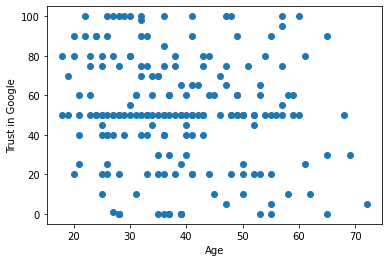

In [12]:
plt.scatter(df["age"], df["google"]);

# можем добавить подписи к осям

plt.xlabel("Age");
plt.ylabel("Trust in Google");

### Задание 8

1. Запишите в общем виде, как должно выглядеть уравнение регрессионной модели для задачи, сформулированной в предыдущем задании (при записи используйте условное математическое ожидание и названия переменных). 
2. Найдите, используя результаты предыдущих заданий, оценки коэффициентов модели $\hat{b}_0$ и $\hat{b}_1$. 
3. Запишите уравнение оценённой модели, используя найденные оценки коэффициентов $\hat{b}_0$ и $\hat{b}_1$.
4. На сколько, в среднем, изменяется значение индекса доверия к Google и другим поисковым системам, если возраст увеличивается на один год? Чему соответствует значение $\hat{b}_0$?

In [13]:
b1 = cov / s2_age
b0 = google_mean - b1 * age_mean
print(b0, b1)

62.701228590347554 -0.29093719554114034


$$
E(google_i|age_i) = b_0 + b_1 \times age_i
$$

$$
\widehat{google}_i = \hat{b}_0 + \hat{b}_1\times age_i
$$

$$
\widehat{google}_i = 62.7 - 0.29 \times age_i
$$

При увеличении возраста на один год индекс доверия к Google, в среднем, уменьшается на 0.29 единиц. Но, так как мы не наблюдаем за людьми в течение нескольких лет, более корректно здесь будет заключить, что, если мы сравним двух людей, отличающихся только по возрасту, согласно нашей модели, у того, кто на год старше, значение индекса доверия к Google будет на 0.29 ниже. Значение 62.7 – это среднее значение индекса доверия у респондентов нулевого возраста ($age_i = 0$). Таких респондентов в выборке быть не может, однако математический смысл константы не теряется, просто содержательно интерпретировать ее в данном случае не имеет смысла.

### Задание 9

Используя значения $\hat{b}_0$ и $\hat{b}_1$ из предыдущей задачи, найдите предсказанные значения зависимой переменной и сохраните их в новый столбец `predicted` в датафрейм `df`.

In [14]:
df["predicted"] = b0 + b1 * df["age"]
df.head()

,age,google,predicted
19,27,80,54.845924
20,21,25,56.591547
21,27,40,54.845924
23,19,50,57.173422
24,25,75,55.427799


### Задание 10

Добавьте в датафрейм `df` столбец `e` с остатками модели ($\varepsilon$). Добавьте в датафрейм `df` столбец `e2` с квадратами остатков модели ($\varepsilon^2$). Найдите сумму квадратов остатков модели RSS.

In [15]:
df["e"] = df["google"] - df["predicted"]
df["e2"] = df["e"] ** 2
rss = df["e2"].sum()
print(rss)

147035.7496425574


### Задание 11

Постройте ещё раз диаграмму рассеивания из задания 7. Добавьте на неё регрессионную прямую. Покажите, как по полученному графику можно находить остатки модели. Покажите, в какой части графика остатки больше нуля, а в какой – меньше.

*Подсказка*: функция `plot()` из модуля `pyplot`, который мы импортировали как `plt`; на вход принимает два массива/столбца датафрейма, значения первого будут идти по горизонтальной оси, второго – по вертикальной; по вертикальной оси должны идти предсказанные значения зависимой переменной.

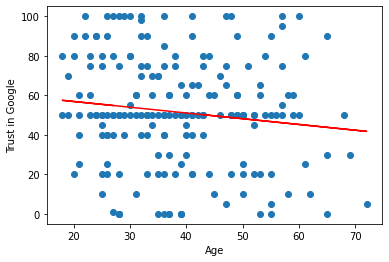

In [17]:
plt.scatter(df["age"], df["google"]);
plt.plot(df["age"], df["predicted"], c = "red");

# можем добавить подписи к осям

plt.xlabel("Age");
plt.ylabel("Trust in Google");

### Заключение – мостик к следующим занятиям

Конечно, Python умеет оценивать регрессионные модели самостоятельно. Мы проделали много манипуляций «с нуля», чтобы закрепить материал лекции и немного подготовиться к проверочной, теперь можем выдохнуть и положиться на автоматику :) 

Итак, импортируем функцию `ols()` из модуля `statsmodels`. Название этой функции – сокращение от *ordinary least squares*, модель, полученная обычным методом наименьших квадратов (МНК), который обсуждался на лекции и который чаще всего используется на практике.

In [18]:
from statsmodels.formula.api import ols

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Оценим модель линейной регрессии на основе данных в датафрейме `df` (зависимая переменная – `google`, независимая – `age`):

In [19]:
# метод .fit() – оценка, подгонка модели,
# вычисление ее коэффициентов и других характеристик

model = ols("google ~ age", data = df).fit()

Так как полное описание модели нам пока не нужно, извлечём из полученного результата только оценки коэффициентов $\hat{b}_0$ и $\hat{b}_1$, то есть константу (`intercept`) и угол наклона прямой (`slope`, в выдачах называется по независимой переменной):

In [20]:
model.params

Intercept    62.701229
age          -0.290937
dtype: float64

При желании можем извлечь из модели предсказанные значения зависимой переменной (те, что мы получили ранее с нуля в `predicted`):

In [21]:
model.predict()

array([54.84592431, 56.59154748, 54.84592431, 57.17342188, 55.4277987 ,
       51.64561516, 45.53593405, 43.79031088, 53.39123833, 49.0271804 ,
       53.10030114, 55.13686151, 50.19092918, 54.26404992, 52.22748955,
       51.35467796, 54.55498712, 52.22748955, 46.99062003, 53.10030114,
       48.15436881, 53.68217553, 41.75375051, 51.35467796, 45.24499686,
       52.22748955, 51.93655236, 55.4277987 , 56.00967309, 48.44530601,
       46.40874564, 48.15436881, 52.51842675, 50.19092918, 55.13686151,
       50.77280357, 54.84592431, 53.39123833, 55.13686151, 46.11780844,
       56.00967309, 46.11780844, 45.82687125, 47.57249442, 47.28155723,
       56.00967309, 52.51842675, 46.11780844, 51.35467796, 47.57249442,
       51.35467796, 47.28155723, 50.77280357, 46.99062003, 49.0271804 ,
       53.97311272, 52.22748955, 50.48186638, 50.77280357, 54.55498712,
       55.4277987 , 53.39123833, 51.93655236, 53.68217553, 53.39123833,
       47.57249442, 53.39123833, 55.13686151, 52.51842675, 53.10

А можем найти предсказанное значение зависимой переменной `google` для человека 42 лет:

In [22]:
# exog – от exogeneous, внешние (новые) данные
# в виде словаря записываем название 
# независимой переменной и её значение

model.predict(exog = {"age" : 42})

0    50.481866
dtype: float64

Или сразу для нескольких людей разного возраста:

In [23]:
# в age сразу список

model.predict(exog = {"age" : [42, 18, 30]})

0    50.481866
1    57.464359
2    53.973113
dtype: float64

Кроме того, можем отдельно поинтересоваться, чему равны остатки (`.resid` от *residuals*):

In [24]:
model.resid

19      25.154076
20     -31.591547
21     -14.845924
23      -7.173422
24      19.572201
          ...    
2048    26.026887
2056   -30.772804
2072    23.354385
2076   -45.427799
2083    29.809071
Length: 195, dtype: float64

И даже получить сумму квадратов остатков (здесь `.ssr` от *sum of squared residuals*, у нас на курсе и вообще в статистике это RSS, мы их тоже уже посчитали ранее «с нуля», можем сравнить):

In [25]:
model.ssr

147035.7496425574

Всё! С более подробным описанием результатов, которые хранятся в объекте `model`, мы познакомимся после следующих лекций.